# Advent of Code 2018
http://adventofcode.com/2018

## Day 1
Puzzle input: `input01.txt`
### Part 1

In [1]:
with open('data/input01.txt', 'r') as f:
    freq_change = [int(n) for n in f]
    
print(sum(freq_change))

576


### Part 2

In [2]:
last_freq = 0
freq_history = set()
n = len(freq_change)

i = 0
while last_freq not in freq_history:
    freq_history.add(last_freq)
    last_freq += freq_change[i]    
    i = (i+1) % n
    
print(last_freq)

77674


## Day 2
Puzzle input: `input02.txt`
### Part 1

In [3]:
with open('data/input02.txt', 'r') as f:
    words = [w.strip() for w in f]

In [4]:
from collections import Counter

twos, threes = 0, 0
for w in words:
    c = Counter(w)
    if 2 in c.values(): twos += 1
    if 3 in c.values(): threes += 1
        
print(twos * threes)

5904


### Part 2

In [5]:
from itertools import combinations

def diff_count(w1, w2):
    return sum(a != b for a,b in zip(w1, w2))

def common(w1, w2):
    return ''.join(a for a,b in zip(w1, w2) if a == b)

for w1, w2 in combinations(words, 2):
    if diff_count(w1, w2) == 1: print(common(w1, w2))

jiwamotgsfrudclzbyzkhlrvp


## Day 3
Puzzle input: `input03.txt`
### Part 1

In [6]:
with open('data/input03.txt', 'r') as f:
    claim_raw = [c.strip() for c in f]

In [7]:
from collections import defaultdict
from re import search

claim_regex = r'\#(\d+)\s+\@\s+(\d+),(\d+)\:\s+(\d+)x(\d+)'

claim_id = defaultdict(set)
for c_raw in claim_raw:
    c_id, i, j, m, n = (int(g) for g in search(claim_regex, c_raw).groups())
    for p in range(i, i+m):
        for q in range(j, j+n):
            claim_id[(p,q)].add(c_id)
            
print(sum(len(claims) > 1 for claims in claim_id.values()))

104241


### Part 2

In [8]:
claim_set = set.union(*claim_id.values())

for position, claims in claim_id.items():
    if len(claims) > 1:
        claim_set -= claim_id[position]
                
print(claim_set)

{806}


## Day 4
Puzzle input: `input04.txt`
### Part 1

In [9]:
with open('data/input04.txt', 'r') as f:
    guard_records = [g.strip() for g in f]

In [10]:
from datetime import datetime, timedelta

guard_regex1 = '\[.+\] Guard \#(\d+)'
guard_regex2 = '\[(\d+)\-(\d+)\-(\d+)\ (\d+)\:(\d+)\] (.+) .+'

asleep = defaultdict(int)
for gr in sorted(guard_records):
    try:
        curr_guard = int(search(guard_regex1, gr).groups()[-1])
    except:
        groups = search(guard_regex2, gr).groups()
        yr, mo, da, hr, mi = (int(g) for g in groups[:-1])
        dt2 = datetime(yr, mo, da, hr, mi)
        if 'falls' in groups[-1]: 
            dt1 = dt2
        if 'wakes' in groups[-1]:
            dt = dt1
            while dt < dt2:
                asleep[(curr_guard, dt.minute)] += 1
                dt += timedelta(minutes = 1)
            dt1 = dt2
            
best_guard = sorted([
    (sum(v for k,v in asleep.items() if k[0] == g), g)
    for g in set(k[0] for k in asleep.keys())
])[-1][1]

best_minute = sorted([
    (v,k) for k,v in asleep.items() 
    if k[0] == best_guard
])[-1][1]

print(best_minute[0] * best_minute[1])

3212


### Part 2

In [11]:
best_minute = sorted([(v,k) for k,v in asleep.items()])[-1][1]
print(best_minute[0] * best_minute[1])

4966


## Day 4: Alternative solution with `pandas`
Puzzle input: `input04.txt`
### Part 1

In [12]:
import pandas as pd

df = (
    pd.read_csv('data/input04.txt', header = None).sort_values(0).iloc[:,0]
    .str.extract(r'\[(\d+)\-(\d+)\-(\d+)\ (\d+)\:(\d+)\] (.+)')
)

df['guard_id'] = df[5].str.extract(r'd \#(\d+)', expand = False).astype(float)
df['date'] = df.iloc[:,:5].astype(int).apply(lambda row: datetime(*row), 1) 
df['asleep'] = df[5].str.contains('sleep')

date_min, date_max = df.date.min(), df.date.max()
total_mins = int((date_max - date_min).total_seconds()) // 60

df = pd.DataFrame({
    'date': [date_min + timedelta(minutes = m) for m in range(total_mins + 1)]
}).merge(df, on = 'date', how = 'left')[['guard_id', 'date', 'asleep']]

df['minute'] = df.date.apply(lambda dt: dt.minute)

df = (
    df.drop('date', 1).fillna(method = 'ffill')
    .groupby(['guard_id', 'minute'], as_index = False).sum()
).astype(int)

print('\nA sample of the processed data:')
df.sample(10)


A sample of the processed data:


,guard_id,minute,asleep
252,709,12,7
827,2371,47,10
1377,3391,57,4
994,2833,34,4
583,1789,43,6
59,73,59,0
596,1789,56,2
1137,3203,57,0
462,1217,42,7
1187,3313,47,6


In [13]:
best_minute = df[
    df.guard_id == df.groupby('guard_id').sum().asleep.idxmax()
].sort_values('asleep').iloc[-1]

print(int(best_minute.guard_id * best_minute.minute))

3212


### Part 2

In [14]:
best_minute = df.sort_values('asleep').iloc[-1]
print(int(best_minute.guard_id * best_minute.minute))

4966


## Day 5
Puzzle input: `input05.txt`
### Part 1

In [15]:
with open('data/input05.txt', 'r') as f:
    polymer = f.read().strip()

In [16]:
from re import sub

units = set(p.lower() for p in polymer)
rgx = '|'.join(u + u.upper() + '|'  + u.upper() + u for u in units)

def react(p):
    result = p
    q = ''
    while result != q:
        q = result
        result = sub(rgx, '', q)
    return result

print(len(react(polymer)))

9060


### Part 2

In [17]:
altered_lengths = sorted(
    (len(react(sub('(?i)' + u, '', polymer))), u) for u in units 
)
for al in altered_lengths[:3]:
    print('A length of {} is obtained by removing unit {}'.format(*al))
print('.\n' * 5)
for al in altered_lengths[-3:]:
    print('A length of {} is obtained by removing unit {}'.format(*al))

A length of 6310 is obtained by removing unit o
A length of 8652 is obtained by removing unit y
A length of 8654 is obtained by removing unit a
.
.
.
.
.

A length of 8732 is obtained by removing unit c
A length of 8748 is obtained by removing unit f
A length of 8756 is obtained by removing unit k


## Day 6
Puzzle input: `input06.txt`
### Part 1

In [18]:
with open('data/input06.txt', 'r') as f:
    coords = [tuple(int(x) for x in p.strip().split(',')) for p in f]

In [19]:
def man_dist(x, y):
    return abs(x[0] - y[0]) + abs(x[1] - y[1])

closest = {}
for i in range(max(x[0] for x in coords) + 2):
    for j in range(max(x[1] for x in coords) + 2):
        dists = sorted((man_dist(x, (i, j)), x) for x in coords)
        if dists[0][0] != dists[1][0]:
            closest[(i,j)] = dists[0][1]
            
infs = set()
M1 = max(x[1] for x in coords)
for i in range(max(x[0] for x in coords) + 2):
    if (i,0) in closest: infs.add(closest[(i, 0)])
    if (i,M1) in closest: infs.add(closest[(i, M1 + 1)])

M0 = max(x[0] for x in coords)
for j in range(max(x[1] for x in coords) + 2):
    if (0, j) in closest: infs.add(closest[(0, j)])
    if (M0 + 1, j) in closest: infs.add(closest[(M0 + 1, j)])

best_a = 0
for c in set(coords) - infs:
    a = len(set(p for p, c_ in closest.items() if c_ == c))
    if a > best_a: best_a = a

print(best_a)

3687


### Part 2

In [20]:
dists = {}
m0 = min(x[0] for x in coords)
m1 = min(x[1] for x in coords)
for i in range(m0 - 200, M0 + 201, 1):    # because 10000 / 50 = 200
    for j in range(m1 - 200, M1 + 201, 1):
        dists[(i, j)] = sum([man_dist((i, j), x) for x in coords])

print(sum(v < 10000 for v in dists.values()))

40134


## Day 7
Puzzle input: `input07.txt`
### Part 1

In [21]:
with open('data/input07.txt', 'r') as f:
    instr = [i.strip() for i in f]

In [22]:
links = set(search(r'(.) must be .+ (.) can be', i).groups() for i in instr)

steps = set(l[0] for l in links) | set(l[1] for l in links)
todo = set(s for s in steps if s not in set(l[1] for l in links))
sequence = []

while len(todo) > 0:
    sequence.append(min(todo))
    links = set(l for l in links if l[0] not in sequence)
    todo = set(s for s in steps 
               if s not in set(l[1] for l in links)
              and s not in sequence)

print(''.join(sequence))

DFOQPTELAYRVUMXHKWSGZBCJIN


### Part 2

In [23]:
links = set(search(r'(.) must be .+ (.) can be', i).groups() for i in instr)

def time_req(s):
    return ord(s) - 4

sequence = []
time_elapsed = -1
worker_time = [1] * 5
worker_letters = [''] * 5

while max(worker_time) > 0 or len(sequence) < len(steps):
    
    for i in range(5): 
        worker_time[i] = max(worker_time[i] - 1, 0)    
    
    seq_done = []
    while 0 in worker_time:
        idx = worker_time.index(0)
        if worker_letters[idx] != '':
            seq_done.append(worker_letters[idx])
            
        links = set(l for l in links if l[0] not in sequence + seq_done)
        
        todo = set(s for s in steps 
                   if s not in set(l[1] for l in links)
                   and s not in sequence + seq_done + worker_letters)  
        
        if len(todo) > 0:
            worker_letters[idx] = min(todo)
            worker_time[idx] = time_req(min(todo))
        else:
            worker_letters[idx] = '' 
            worker_time, worker_letters = (
                list(w) for w in 
                zip(*sorted(zip(worker_time, worker_letters))[::-1])
            )
            break
    sequence += sorted(seq_done)
    time_elapsed += 1
    
print(time_elapsed)


1036


## Day 8
Puzzle input: `input08.txt`
### Part 1

In [24]:
with open('data/input08.txt', 'r') as f:
    inp = [int(i) for i in f.readline().split(' ')]

In [25]:
nodes = dict()
i = 0
nn = [0]
pn = [-1]
mnn = 0
child_count = [inp[i]]
meta_count = [inp[i+1]]
i += 2
while len(child_count) > 0:
    while child_count[-1] > 0:
        pn.append(nn[-1])
        nn.append(mnn + 1)
        mnn += 1
        child_count.append(inp[i])
        meta_count.append(inp[i+1])
        i += 2
    
    nodes[nn[-1]] = (pn[-1], inp[i:i+meta_count[-1]])
    i += meta_count[-1]
    child_count.pop()
    if len(child_count) == 0:
        break
    meta_count.pop()
    nn.pop()
    pn.pop()
    child_count[-1] -= 1
    
    # There's gotta be a cleaner way than this WTF
    while child_count == 0:
        nodes[nn[-1]] = (pn[-1], inp[i:i+meta_count[-1]])
        i += meta_count[-1]
        child_count.pop()
        if len(child_count) == 0:
            break
        meta_count.pop()
        nn.pop()
        pn.pop()
        child_count[-1] -= 1        
        
print(sum(sum(v[1]) for v in nodes.values()))        

49180


### Part 2

In [26]:
children = defaultdict(list)
for k,v in nodes.items():
    children[v[0]].append(k)

weighted_children = defaultdict(list)
for k,val in children.items():
    if k == -1: continue
    sv = sorted(val)
    for i in nodes[k][1]:
        try:
            weighted_children[k].append(sv[i-1])
        except:
            pass

leaves = set(nodes) - set(v[0] for v in nodes.values())
def weight(n):
    if n in leaves:
        return sum(nodes[n][1])
    return sum(weight(m) for m in weighted_children[n])

print(weight(0))

20611


## Day 9
Puzzle input: `448 players; last marble is worth 71628 points`
### Part 1

In [27]:
player_count = 448
last_marble_val = 71628

In [28]:
curr_player = -1
scores = [0] * player_count
circle = [0]
curr_pos = 0
for curr_marble in range(1, last_marble_val):
    curr_player = (curr_player + 1) % player_count
    if curr_marble % 23 > 0:
        curr_pos = (curr_pos + 2) % len(circle)
        circle.insert(curr_pos, curr_marble)
    else:
        scores[curr_player] += curr_marble
        curr_pos = (curr_pos - 7) % len(circle)
        scores[curr_player] += circle.pop(curr_pos) 

print(max(scores))

394486


### Part 2

In [29]:
from collections import deque  # pulling out the big guns :o
last_marble_val *= 100

In [30]:
curr_player = -1
scores = [0] * player_count
circle = deque([0], last_marble_val)
for curr_marble in range(1, last_marble_val):
    curr_player = (curr_player + 1) % player_count
    if curr_marble % 23 > 0:
        circle.rotate(2)
        circle.append(curr_marble)
    else:
        circle.rotate(-7)
        scores[curr_player] += curr_marble + circle.pop()

print(max(scores))

3276488008


## Day 10
Puzzle input: `input10.txt`
### Part 1

In [31]:
with open('data/input10.txt', 'r') as f:
    points = [p.strip() for p in f]

In [32]:
x, y, vx, vy = [], [], [], []
for p in points:
    new = search(r'.+\<(.+),(.+)\>.+<(.+),(.+)\>', p).groups()
    x.append(int(new[0]))
    y.append(int(new[1]))
    vx.append(int(new[2]))
    vy.append(int(new[3]))

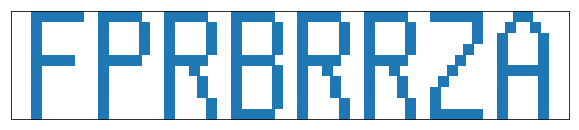

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 2

x_diversity = [len(set(np.array(x) + t*np.array(vx))) for t in range(100000)]
t = x_diversity.index(min(x_diversity))    

plt.scatter(
    np.array(x) + t*np.array(vx),
  -(np.array(y) + t*np.array(vy)),
    marker  = 's',  s = 100
)
plt.xticks([]), plt.yticks([])
plt.show()

### Part 2

In [34]:
print(t)

10027


## Day 11: My original, much-too-slow solution
Puzzle input: `8868`
### Part 1

In [35]:
serial_no = 8868

In [36]:
%%time
power_level = {}
for x in range(1,301):
    for y in range(1,301):
        power_level[(x,y)] = (((x+10)*y + serial_no)*(x+10) // 100) % 10 - 5

total_power = defaultdict(int)
for x in range(1,299):
    for y in range(1,299):
        for i in range(3):
            for j in range(3):
                total_power[(x,y)] += power_level[(x+i,y+j)]

mp = max(total_power.values())
print([k for k,v in total_power.items() if v == mp])

[(241, 40)]
Wall time: 671 ms


### Part 2

In [37]:
%%time
total_power = defaultdict(int)
for sqs in range(1,301):
    for x in range(1,301-sqs+1):
        for y in range(1,301-sqs+1):
            total_power[(x,y,sqs)] = total_power[(x,y,sqs-1)]
            for i in range(sqs):
                total_power[(x,y,sqs)] += power_level[(x+i,y+sqs-1)]
            for j in range(sqs-1):
                total_power[(x,y,sqs)] += power_level[(x+sqs-1,y+j)]

mp = max(total_power.values())
print([k for k,v in total_power.items() if v == mp])

[(166, 75, 12)]
Wall time: 13min 11s


## Day 11: Faster solution with `numpy`
### Part 1

In [38]:
serial_no = 8868

In [39]:
%%time
power_level = np.zeros((301,301))

for x in range(1,301):  # note: not converting problem to zero-indexed
    for y in range(1,301):
        power_level[x,y] = (((x+10)*y + serial_no)*(x+10) // 100) % 10 - 5

total_power = defaultdict(int)
for x in range(1,299):
    for y in range(1,299):
        total_power[(x,y)] += np.sum(power_level[x:x+3,y:y+3])

mp = max(total_power.values())
print([k for k,v in total_power.items() if v == mp])

[(241, 40)]
Wall time: 874 ms


### Part 2

In [40]:
%%time
total_power = defaultdict(int)
for sqs in range(1,301):
    for x in range(1,301-sqs+1):
        for y in range(1,301-sqs+1):
            total_power[(x,y,sqs)] = (
                total_power[(x,y,sqs-1)]
                + np.sum(power_level[x:x+sqs,y+sqs-1]) 
                + np.sum(power_level[x+sqs-1,y:y+sqs-1])
            )

mp = max(total_power.values())
print([k for k,v in total_power.items() if v == mp])

[(166, 75, 12)]
Wall time: 2min 16s


## Day 12
Puzzle input: `input12.txt`
### Part 1

In [41]:
with open('data/input12.txt', 'r') as f:
    lines = [l.strip() for l in f]

In [42]:
pots = defaultdict(lambda: '.')
for i,c in enumerate(lines[0].replace('initial state: ','').strip()):
    pots[i] = c

rules = defaultdict(lambda: '.')
for k,v in [l.strip().split(' => ') for l in lines[2:]]:
    rules[k] = v
    
def next_step(i, pots):
    key = ''.join(pots[k] for k in range(i-2,i+3))
    return rules[key]

for gen in range(20):
    new_pots = pots.copy()
    for i in range(min(pots.keys()) - 1, max(pots.keys()) + 2):
        new_pots[i] = next_step(i, pots)
    pots = new_pots.copy()
    
print(sum(k for k,v in pots.items() if v == '#'))

3059


### Part 2

In [43]:
gens, sums = [], []
for gen in range(20, 500):
    new_pots = pots.copy()
    for i in range(min(pots.keys()) - 1, max(pots.keys()) + 2):
        new_pots[i] = next_step(i, pots)
    pots = new_pots.copy()
    if (gen+1) % 100 == 0:
        gens.append(gen+1)
        sums.append(sum(k for k,v in pots.items() if v == '#'))

# Use point-slope form to extapolate (LOL!): y = m(x - x0) + y0
m = (sums[-1] - sums[-2]) / (gens[-1] - gens[-2])
print(int(m*(50000000000 - gens[-2]) + sums[-2]))

3650000001776


## Day 13
Puzzle input: `input13.txt`
### Parts 1 & 2

In [44]:
with open('data/input13.txt', 'r') as f:
    track = [list(t) for t in f]
assert len(set(len(t) for t in track)) == 1

In [45]:
cars = []
orig_track = []

for t in track: 
    orig_track.append([])
    for c in t:
        orig_track[-1].append(c)
        
for i in range(len(track)):
    for j in range(len(track[0])):
        if track[i][j] in ['<','>','v','^']:
            cars.append((i,j,'L'))
            if track[i][j] in ['<','>']:
                orig_track[i][j] = '-'
            else:
                orig_track[i][j] = '|'
                
cars = sorted(cars)

In [46]:
turn = {'R': 'L', 'L': 'F', 'F': 'R'}

move = {'>': (0,1), '<': (0,-1), 'v': (1,0), '^': (-1,0)}

new_dir = {('>','R'): 'v', ('>','L'): '^', ('>','F'): '>',
           ('v','R'): '<', ('v','L'): '>', ('v','F'): 'v',
           ('^','R'): '>', ('^','L'): '<', ('^','F'): '^',
           ('<','R'): '^', ('<','L'): 'v', ('<','F'): '<'}

slash = {'>': '^', '<': 'v', 'v': '<', '^': '>'}
bslash = {'>': 'v', '<': '^', 'v': '>', '^': '<'}

while len(cars) > 1:

    k = 0
    while k < len(cars):
        i,j,t = cars[k]

        di,dj = move[track[i][j]]
        track[i+di][j+dj] = track[i][j]
        track[i][j] = orig_track[i][j]
        
        if orig_track[i+di][j+dj] == '+':
            track[i+di][j+dj] = new_dir[(track[i+di][j+dj], t)]
            cars[k] = (i+di,j+dj,turn[t])
        else:
            cars[k] = (i+di,j+dj,t)            
            if orig_track[i+di][j+dj] == '/':
                track[i+di][j+dj] = slash[track[i+di][j+dj]]
            if orig_track[i+di][j+dj] == '\\':
                track[i+di][j+dj] = bslash[track[i+di][j+dj]]

        crashed = [key for key,val in Counter(c[:2] for c in cars).items() 
                   if val > 1]     
        
        if len(crashed) > 0:
            for ir,jr in crashed:
                print('Crash at %d,%d' % (jr,ir))
                cut_cnt = sum(c[:2] == (ir,jr) and kr <= k 
                             for kr, c in enumerate(cars))
                track[ir][jr] = orig_track[ir][jr]
                cars = [c for c in cars if c[:2] != (ir,jr)]
                k += 1 - cut_cnt
        else:
            k += 1    
        
    cars = sorted(cars)

print('\nLocation of the last cart: %d,%d' % cars[0][1::-1])

Crash at 26,92
Crash at 75,73
Crash at 113,72
Crash at 26,100
Crash at 68,6
Crash at 23,69
Crash at 26,103
Crash at 84,37

Location of the last cart: 86,18


## Day 14
Puzzle input: `327901`
### Part 1

In [47]:
num_recipes = 327901
elf1, elf2 = 3, 7
recipes = [elf1, elf2]
elf1_pos, elf2_pos = 0, 1

In [48]:
while len(recipes) < num_recipes + 10:
    recipes += [int(d) for d in str(elf1 + elf2)]
    elf1_pos = (elf1_pos + elf1 + 1) % len(recipes)
    elf2_pos = (elf2_pos + elf2 + 1) % len(recipes)
    elf1 = recipes[elf1_pos]
    elf2 = recipes[elf2_pos]
    
print(''.join(str(i) for i in recipes[num_recipes:num_recipes + 10]))

1115317115


### Part 2

In [49]:
num_recipes = str(num_recipes)
elf1, elf2 = 3, 7
recipes = [elf1, elf2]
elf1_pos, elf2_pos = 0, 1
recipe_str = str(elf1) + str(elf2)

In [50]:
nl = len(num_recipes)
while recipe_str.find(num_recipes, len(recipes) - nl - 3) < 0:
    recipes += [int(d) for d in str(elf1 + elf2)]
    recipe_str += str(elf1 + elf2)
    elf1_pos = (elf1_pos + elf1 + 1) % len(recipes)
    elf2_pos = (elf2_pos + elf2 + 1) % len(recipes)
    elf1 = recipes[elf1_pos]
    elf2 = recipes[elf2_pos]

print(recipe_str.find(num_recipes, len(recipes) - nl - 3))

20229822


## Day 15
Puzzle input: `input15.txt`

**NOTE**: My original solution required no imports and correctly solved all the provided test cases, but it could not scale to the size of the main task. The solution below uses the [`dijkstar` package](https://pypi.org/project/Dijkstar/), which I don't have any previous experience with.

### Part 1

In [51]:
from dijkstar import Graph, find_path, NoPathError 
from itertools import product
from IPython.display import clear_output   # for animation
from time import sleep   

In [52]:
with open('data/input15.txt', 'r') as f:
    cave = [list(l.strip()) for l in f]
assert len(set(len(c) for c in cave)) == 1
    
hp = [[200 if c in ('E', 'G') else 0 for c in l] for l in cave]

def dist(p, q):
    return abs(p[0] - q[0]) + abs(p[1] - q[1])

graph = Graph()
for i,j,k,l in product(range(len(cave)), range(len(cave[0])), repeat = 2):
    if cave[i][j] == '#' or cave[k][l] == '#' or dist((i,j),(k,l)) != 1: 
        continue
    graph.add_edge((i,j), (k,l))

In [53]:
def cave_print(cave):
    print('\n'.join(' '.join(c) for c in cave))

def curr_graph(cave):
    ret_graph = Graph(graph)
    for i,j in product(range(len(cave)), range(len(cave[0]))):
        if cave[i][j] in ('E', 'G'):
            ret_graph.pop((i,j))
    return ret_graph

def adjacent(i, j, cave):
    return [(k,l) for k,l in ((i-1,j),(i,j-1),(i,j+1),(i+1,j)) 
            if cave[k][l] == '.']

def get_pd_func(cave):
    cg = curr_graph(cave)
    
    def path_dist(p, q):
        try:
            return len(
                find_path(cg, p, q, cost_func = lambda *args: 1).nodes
            ) - 1
        except NoPathError:
            return float('inf')
        
    return path_dist
    
def get_locs(chars, cave):
    return [(k,l) for k,l in product(range(len(cave)), range(len(cave[0]))) 
            if cave[k][l] in chars]

def move(i, j, cave):
    if cave[i][j] == 'E': targchar = 'G'
    else: targchar = 'E'

    path_dist = get_pd_func(cave)
    
    if min(dist((i,j), (k,l)) for k,l in get_locs(targchar, cave)) == 1:
        return None
    
    poss = []
    for i1, j1 in adjacent(i, j, cave):
        for k1, l1 in set.union(*[set(adjacent(k, l, cave))
                                  for k, l in get_locs(targchar, cave)]):
            poss.append((path_dist((i1, j1), (k1, l1)), 
                         (k1, l1), (i1, j1)))
            
    poss = sorted(poss)
    if len(poss) == 0 or poss[0][0] == float('inf'): return None
    return poss[0][-1]
        
def game_over_man(cave):
    return len(set.union(*[set(c) for c in cave]) & {'E', 'G'}) < 2

def action(i, j, cave):
    if cave[i][j] not in ('E', 'G'): return None
    if game_over_man(cave): return None

    if cave[i][j] == 'E': targchar = 'G'
    else: targchar = 'E'
    
    m = move(i, j, cave)
    
    if m is not None:
        i1, j1 = m
        cave[i1][j1] = cave[i][j]
        hp[i1][j1] = hp[i][j]
        cave[i][j] = '.'
        hp[i][j] = 0        
        i, j = i1, j1
        
    opponents = [(k,l) for k,l in [(i-1,j), (i,j-1), (i,j+1), (i+1,j)] 
                 if cave[k][l] == targchar]

    if len(opponents) > 0:
        k,l = sorted(opponents, key = lambda x: (hp[x[0]][x[1]], x))[0]
        hp[k][l] -= 3
        if hp[k][l] <= 0: 
            cave[k][l] = '.'
            hp[k][l] = 0
            
    return (i,j)

In [54]:
rounds = 0
while not game_over_man(cave):
    
    exclude = set()
    for i in range(len(cave)):
        for j in range(len(cave[0])):
            if game_over_man(cave): 
                break
            if (i,j) not in exclude:
                act = action(i,j,cave)
                if act is not None:
                    exclude.add(act)
                    sleep(.05)
                    clear_output(True)
                    print('After round', rounds)
                    print('\n'.join(' '.join(c) for c in cave))
        else:
            continue
        break
    else:
        rounds += 1
        continue
    break

print('\n')
print(rounds, '*',sum(sum(hp ,[])), '=')
print(sum(sum(hp ,[])) * rounds)        


After round 105
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . . # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . . . # # # # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . # . . # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . . . . # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . . . . . # # # # # # # # # # # # # # # #
# # # . # # # # . . . # . . . . # # # # # # # # # # # # # # # #
# . . . . # # # . # # # . . . . . # # # # # # # # # # # # # # #
# # . . . . . . # # # # . . . . . # . # . . . # . # # # # # # #
# # # . . . . . . # # # . . . . . . . . . # . . . # # # # # # #
# # # . . . . . . # # . . . . . . . . . . . # # # # # # # # # #
# . . . . . . . . . . . . . # # # # # . . G # # # # # # # # # #
# . . . # # . . . . . . . # # # # # # # . . # # # # # # # # # #
# . . . # . . . . . . . # # # # # # # # # . . # # # # # # # # #
# # # # . . . . . . . . 

### Part 2

In [55]:
with open('data/input15.txt', 'r') as f:
    cave = [list(l.strip()) for l in f]
assert len(set(len(c) for c in cave)) == 1
    
hp = [[200 if c in ('E', 'G') else 0 for c in l] for l in cave]

In [56]:
def action(i, j, cave, power = 3):
    if cave[i][j] not in ('E', 'G'): return None
    if game_over_man(cave): return None

    if cave[i][j] == 'E': targchar = 'G'
    else: targchar = 'E'
    
    m = move(i, j, cave)
    
    if m is not None:
        i1, j1 = m
        cave[i1][j1] = cave[i][j]
        hp[i1][j1] = hp[i][j]
        cave[i][j] = '.'
        hp[i][j] = 0        
        i, j = i1, j1
        
    opponents = [(k,l) for k,l in [(i-1,j), (i,j-1), (i,j+1), (i+1,j)] 
                 if cave[k][l] == targchar]

    if len(opponents) > 0:
        k,l = sorted(opponents, key = lambda x: (hp[x[0]][x[1]], x))[0]
        hp[k][l] -= power if cave[i][j] == 'E' else 3
        if hp[k][l] <= 0: 
            cave[k][l] = '.'
            hp[k][l] = 0
            
    return (i,j)

In [57]:
rounds = 0
while not game_over_man(cave):
    
    exclude = set()
    for i in range(len(cave)):
        for j in range(len(cave[0])):
            if game_over_man(cave): 
                break
            if (i,j) not in exclude:
                act = action(i,j,cave,19)  # 19 was determined experimentally
                if act is not None: 
                    exclude.add(act)
                    sleep(.05)
                    clear_output(True)
                    print('After round', rounds)
                    print('\n'.join(' '.join(c) for c in cave))
        else:
            continue
        break
    else:
        rounds += 1
        continue
    break

print('\n')
print(rounds, '*',sum(sum(hp ,[])), '=')
print(sum(sum(hp ,[])) * rounds)        


After round 40
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . . # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # . . . # # # # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . # . . # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . . . . # # # # # # # # # # # # # # # # #
# # # # # # # # . . . . . . . . # # # # # # # # # # # # # # # #
# # # . # # # # . . . # . . . . # # # # # # # # # # # # # # # #
# . . . . # # # . # # # . . . . . # # # # # # # # # # # # # # #
# # . . . . . . # # # # . . . . . # . # . . . # . # # # # # # #
# # # . . . . . . # # # . . . . . . E . . # . . . # # # # # # #
# # # . . . . . . # # . . . . . . E . . . . # # # # # # # # # #
# . . . . . . . . . . . . . # # # # # . . . # # # # # # # # # #
# . . . # # . . . . . . . # # # # # # # . . # # # # # # # # # #
# . . . # . . . E . . . # # # # # # # # # . . # # # # # # # # #
# # # # . . . . . . E . #

## Day 16
Puzzle input: `input16.txt`
### Part 1

In [58]:
with open('data/input16.txt', 'r') as f:
    lines = [l.strip() for l in f]

In [59]:
def ops(code, reg, A, B):
    
    if code == 'addr': return reg[A] + reg[B]
    if code == 'addi': return reg[A] + B
    
    if code == 'mulr': return reg[A] * reg[B]
    if code == 'muli': return reg[A] * B
    
    if code == 'banr': return reg[A] & reg[B]
    if code == 'bani': return reg[A] & B
    
    if code == 'borr': return reg[A] | reg[B]
    if code == 'bori': return reg[A] | B
    
    if code == 'setr': return reg[A]
    if code == 'seti': return A
    
    if code == 'gtir': return 1 if A > reg[B] else 0
    if code == 'gtri': return 1 if reg[A] > B else 0
    if code == 'gtrr': return 1 if reg[A] > reg[B] else 0
    
    if code == 'eqir': return 1 if A == reg[B] else 0
    if code == 'eqri': return 1 if reg[A] == B else 0
    if code == 'eqrr': return 1 if reg[A] == reg[B] else 0
    

In [60]:
codes = ['addr', 'addi', 'mulr', 'muli', 'banr', 'bani',
         'borr', 'bori', 'setr', 'seti', 'gtir', 'gtri',
         'gtrr', 'eqir', 'eqri', 'eqrr']

In [61]:
sample_count = sum('After' in l for l in lines)
poss = defaultdict(set)
poss2 = defaultdict(set)

for sampnum in range(sample_count):
    pre_regs = eval(search(r'(\[.+\])', lines[4*sampnum]).groups()[0])
    codenum, A, B, C = lines[4*sampnum + 1].split(' ')
    post_regs = eval(search(r'(\[.+\])', lines[4*sampnum+2]).groups()[0])

    for code in codes:
        if post_regs[int(C)] == ops(code, pre_regs, int(A), int(B)):
            poss[sampnum].add(code)
            poss2[int(codenum)].add(code)

print(sum(len(v) >= 3 for k,v in poss.items()))

542


### Part 2

In [62]:
code_dict = dict()
while len(code_dict) < len(poss2):
    for k,v in poss2.items():
        if len(v) == 1: code_dict[k] = v.pop()
    known = set(v for k,v in code_dict.items())
    for k,v in poss2.items(): 
        poss2[k] = v - known

In [63]:
regs = [0]*4
for l in lines[4*sample_count+2:]:
    codenum, A, B, C = l.split(' ')
    regs[int(C)] = ops(code_dict[int(codenum)], regs, int(A), int(B))
    
print(regs[0])

575


## Day 17
Puzzle input: `input17.txt`
### Part 1

In [64]:
with open('data/input17.txt', 'r') as f:
    lines = [l.strip() for l in f]

slice = defaultdict(lambda *args: '.')
for l in lines:
    var1, val1, var2, val2a, val2b = search(
        r'(.)=(\d+), (.)=(\d+)\.\.(\d+)',l
    ).groups()
    if var1 == 'x' and var2 == 'y':
        for y in range(int(val2a), int(val2b)+1):
            slice[(y, int(val1))] = '#'
    elif var1 == 'y' and var2 == 'x':
        for x in range(int(val2a), int(val2b)+1):
            slice[(int(val1), x)] = '#'

In [65]:
yrange = (min(k[0] for k in slice.keys()), max(k[0] for k in slice.keys()))

def count_reached(slice):
    return sum(v in ('|','~') for k, v in slice.items() 
               if yrange[0] <= k[0] <= yrange[1])

def under(loc):
    return (loc[0]+1, loc[1])

def right(loc):
    return (loc[0], loc[1]+1)

def left(loc):
    return (loc[0], loc[1]-1)

def between(l, r):
    return[(l[0], k) for k in range(l[1]+1, r[1])]

In [66]:
tops = [(0,500)]
bottoms = []
cr = -1

while(count_reached(slice) > cr):

    cr = count_reached(slice)

    remove_tops = [] 
    for t in tops:
        u = t
        while slice[under(u)] not in ('#', '~') and u[0] <= yrange[1]:
            slice[u] = '|'
            u = under(u)
        if u[0] <= yrange[1]:
            bottoms.append(u)
        else:
            remove_tops.append(t)

    for b in bottoms:
        l = b
        while slice[left(l)] != '#' and slice[under(left(l))] in ('#', '~'):
            slice[l] = '|'
            l = left(l)
        if slice[under(left(l))] not in ('#', '~'):
            slice[l] = '|'
            l = left(l)
            tops.append(l)
        lside = left(l)

        r = b
        while slice[right(r)] != '#' and slice[under(right(r))] in ('#', '~'):
            slice[r] = '|'
            r = right(r)
        if slice[under(right(r))] not in ('#', '~'):
            slice[r] = '|'
            r = right(r)
            tops.append(r)
        rside = right(r)

        if slice[lside] == slice[rside] == '#':
            for p in between(lside, rside):
                slice[p] = '~'
        else:
            for p in between(lside, rside):
                slice[p] = '|'

    bottoms = []
    tops = list(set(tops) - set(remove_tops))
    
print(cr)

29063


### Part 2

In [67]:
print(sum(v == '~' for k, v in slice.items() 
          if yrange[0] <= k[0] <= yrange[1]))

23811
